In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Health%20Insurance%20Cross%20Sell%20Prediction%20%F0%9F%8F%A0%20%F0%9F%8F%A5/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Health%20Insurance%20Cross%20Sell%20Prediction%20%F0%9F%8F%A0%20%F0%9F%8F%A5/test.csv")
sub = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Health%20Insurance%20Cross%20Sell%20Prediction%20%F0%9F%8F%A0%20%F0%9F%8F%A5/sample_submission.csv")

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.shape

(381109, 12)

In [5]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
train.drop("id",axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.00,0.05,0.50,0.95,0.99,1.00
Age,20.0,21.0,36.0,69.0,77.0,85.0
Driving_License,0.0,1.0,1.0,1.0,1.0,1.0
Region_Code,0.0,5.0,28.0,47.0,50.0,52.0
Previously_Insured,0.0,0.0,0.0,1.0,1.0,1.0
Annual_Premium,2630.0,2630.0,31669.0,55176.0,72963.0,540165.0
Policy_Sales_Channel,1.0,26.0,133.0,160.0,160.0,163.0
Vintage,10.0,24.0,154.0,285.0,297.0,299.0
Response,0.0,0.0,0.0,1.0,1.0,1.0


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical, and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
                the class threshold for numeric but categorical variables
        car_th: int, optinal
                the class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical Variables List
        num_cols: list
                Numeric Variables List
        cat_but_car: list
                Categorical but cardinal variables list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is in cat_cols

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 381109
Variables: 12
cat_cols: 6
num_cols: 6
cat_but_car: 0
num_but_cat: 3


In [8]:
cat_cols

['Gender',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Driving_License',
 'Previously_Insured',
 'Response']

        Gender     Ratio
Male    206089  54.07613
Female  175020  45.92387


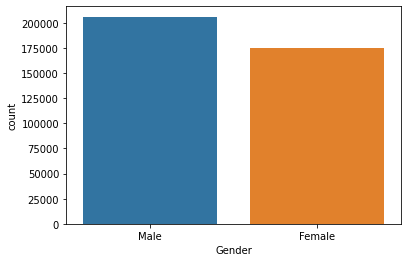

           Vehicle_Age      Ratio
1-2 Year        200316  52.561341
< 1 Year        164786  43.238549
> 2 Years        16007   4.200111


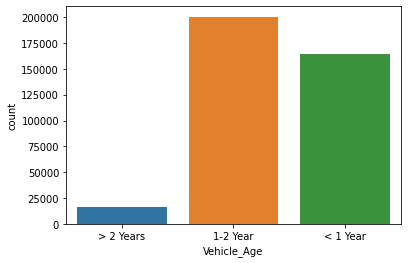

     Vehicle_Damage      Ratio
Yes          192413  50.487656
No           188696  49.512344


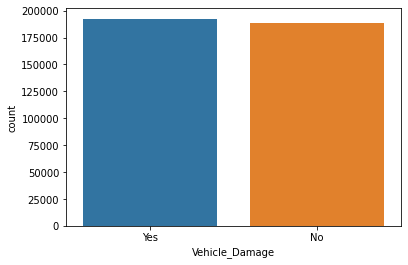

   Driving_License      Ratio
1           380297  99.786938
0              812   0.213062


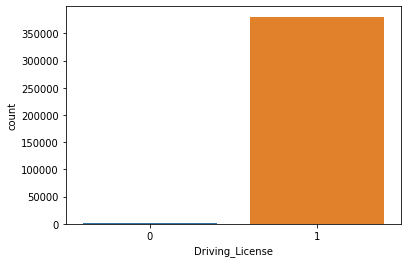

   Previously_Insured      Ratio
0              206481  54.178988
1              174628  45.821012


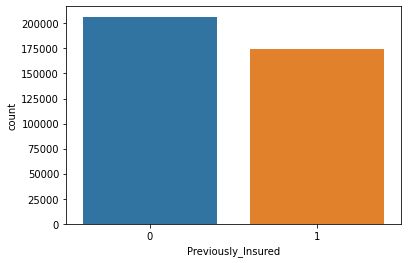

   Response      Ratio
0    334399  87.743664
1     46710  12.256336


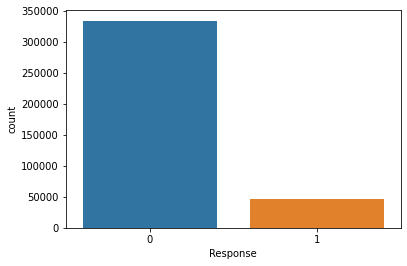

In [9]:
num_cols = [col for col in num_cols if "id" not in col]
num_cols = [col for col in num_cols if "Policy_Sales_Channel" not in col]
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for i in cat_cols:
    cat_summary(train, i, plot=True)

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
5%           21.000000
10%          22.000000
20%          24.000000
30%          25.000000
40%          29.000000
50%          36.000000
60%          42.000000
70%          47.000000
80%          53.000000
90%          62.000000
95%          69.000000
99%          77.000000
max          85.000000
Name: Age, dtype: float64


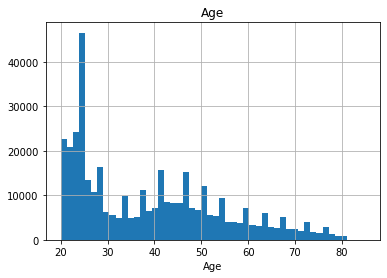

#####################################
count    381109.000000
mean         26.388807
std          13.229888
min           0.000000
5%            5.000000
10%           8.000000
20%          11.000000
30%          18.000000
40%          28.000000
50%          28.000000
60%          28.000000
70%          31.000000
80%          39.000000
90%          46.000000
95%          47.000000
99%          50.000000
max          52.000000
Name: Region_Code, dtype: float64


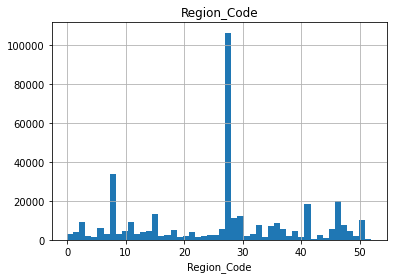

#####################################
count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
5%         2630.000000
10%        2630.000000
20%       21583.600000
30%       26238.000000
40%       29082.000000
50%       31669.000000
60%       34406.000000
70%       37548.000000
80%       41711.000000
90%       48431.000000
95%       55176.000000
99%       72963.000000
max      540165.000000
Name: Annual_Premium, dtype: float64


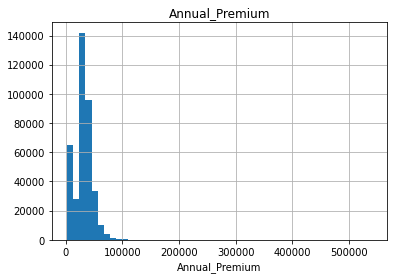

#####################################
count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
5%           24.000000
10%          38.000000
20%          68.000000
30%          96.000000
40%         125.000000
50%         154.000000
60%         183.000000
70%         212.000000
80%         241.000000
90%         270.000000
95%         285.000000
99%         297.000000
max         299.000000
Name: Vintage, dtype: float64


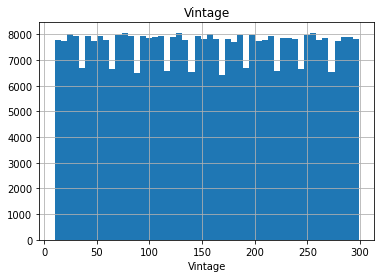

#####################################


In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

for col in num_cols:
    num_summary(train, col, plot=True)

In [11]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
for col in num_cols:
    target_summary_with_num(train, "Response", col)

                Age
Response           
0         38.178227
1         43.435560


          Region_Code
Response             
0           26.336544
1           26.762963


          Annual_Premium
Response                
0           30419.160276
1           31604.092742


             Vintage
Response            
0         154.380243
1         154.112246




<AxesSubplot:xlabel='Age'>

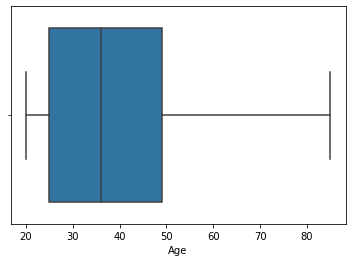

In [12]:
sns.boxplot(x=train["Age"])

<AxesSubplot:xlabel='Annual_Premium'>

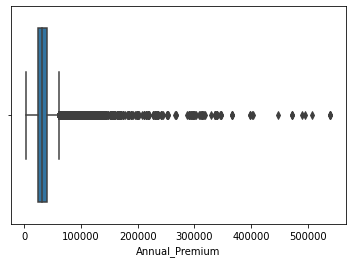

In [13]:
sns.boxplot(x=train["Annual_Premium"])

<AxesSubplot:xlabel='Vintage'>

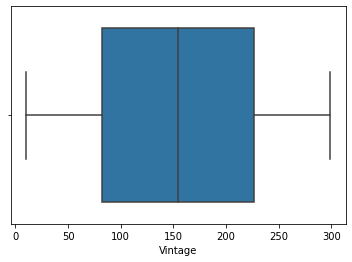

In [14]:
sns.boxplot(x=train["Vintage"])

<AxesSubplot:xlabel='Gender', ylabel='count'>

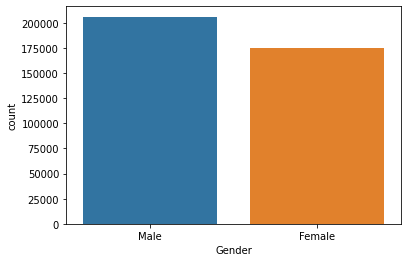

In [15]:
sns.countplot(train.Gender)

In [16]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
for col in num_cols:
    target_summary_with_num(train, "Response", col)

                Age
Response           
0         38.178227
1         43.435560


          Region_Code
Response             
0           26.336544
1           26.762963


          Annual_Premium
Response                
0           30419.160276
1           31604.092742


             Vintage
Response            
0         154.380243
1         154.112246




<AxesSubplot:xlabel='Age'>

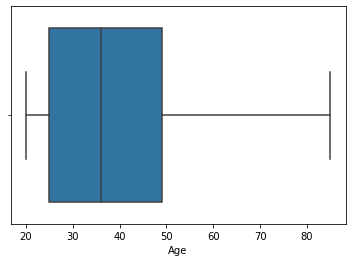

In [17]:
sns.boxplot(x=train["Age"])

<AxesSubplot:xlabel='Annual_Premium'>

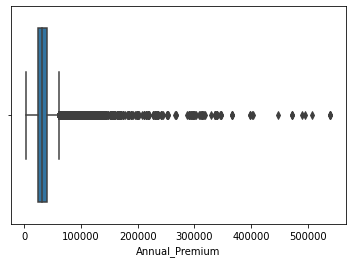

In [18]:
sns.boxplot(x=train["Annual_Premium"])

<AxesSubplot:xlabel='Gender', ylabel='count'>

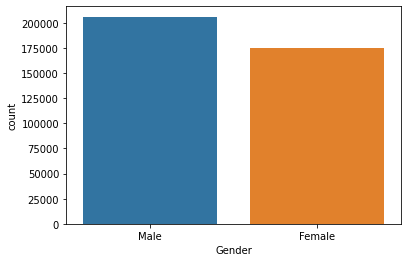

In [19]:
sns.countplot(train.Gender)

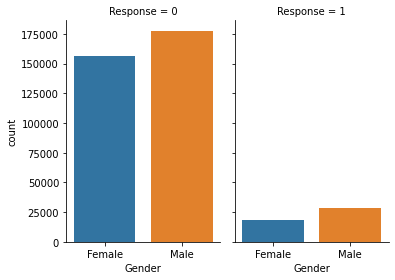

In [20]:
df=train.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="Gender", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

In [21]:
df=train.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()
df

,Gender,Driving_License
0,Female,175020
1,Male,206089


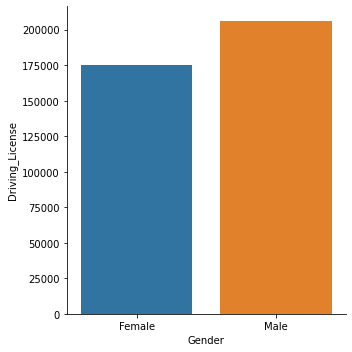

In [22]:
sns.catplot(x="Gender", y="Driving_License",
                data=df, kind="bar");

In [23]:
df=train.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

,Vehicle_Age,Response,count
0,1-2 Year,0,165510
1,1-2 Year,1,34806
2,< 1 Year,0,157584
3,< 1 Year,1,7202
4,> 2 Years,0,11305
5,> 2 Years,1,4702


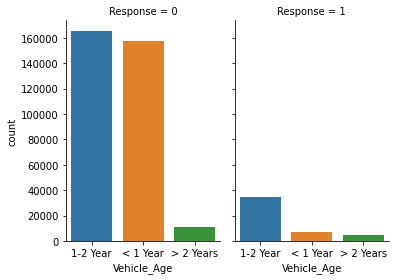

In [24]:
g = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

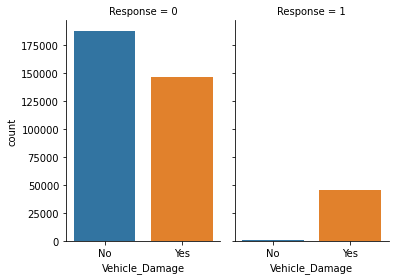

In [25]:
df=train.groupby(['Vehicle_Damage','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="Vehicle_Damage", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

In [26]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 3 * interquantile_range
    low_limit = quartile1 - 3 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

Age : False
Region_Code : False
Annual_Premium : True
Vintage : False


In [27]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
for col in num_cols:
    col, grab_outliers(train, col)

Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []
Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []
          id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
1412    1413  Female   41                1         28.0                   0   
11319  11320  Female   50                1         46.0                   1   
13426  13427  Female   47                1         28.0                   0   
15024  15025  Female   32                1         28.0                   0   
25532  25533    Male   50                1         28.0                   0   

      Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
1412     1-2 Year            Yes        267698.0                 124.0   

In [28]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
for col in num_cols:
    replace_with_thresholds(train, col)
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

Age : False
Region_Code : False
Annual_Premium : False
Vintage : False


In [29]:
train.drop("id",axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.00,0.05,0.50,0.95,0.99,1.00
Age,20.0,21.0,36.0,69.0,77.0,85.0
Driving_License,0.0,1.0,1.0,1.0,1.0,1.0
Region_Code,0.0,5.0,28.0,47.0,50.0,52.0
Previously_Insured,0.0,0.0,0.0,1.0,1.0,1.0
Annual_Premium,2630.0,2630.0,31669.0,55176.0,72963.0,212814.0
Policy_Sales_Channel,1.0,26.0,133.0,160.0,160.0,163.0
Vintage,10.0,24.0,154.0,285.0,297.0,299.0
Response,0.0,0.0,0.0,1.0,1.0,1.0


,1,2,corr
0,Policy_Sales_Channel,Age,-0.890519
36,id,id,1.000000


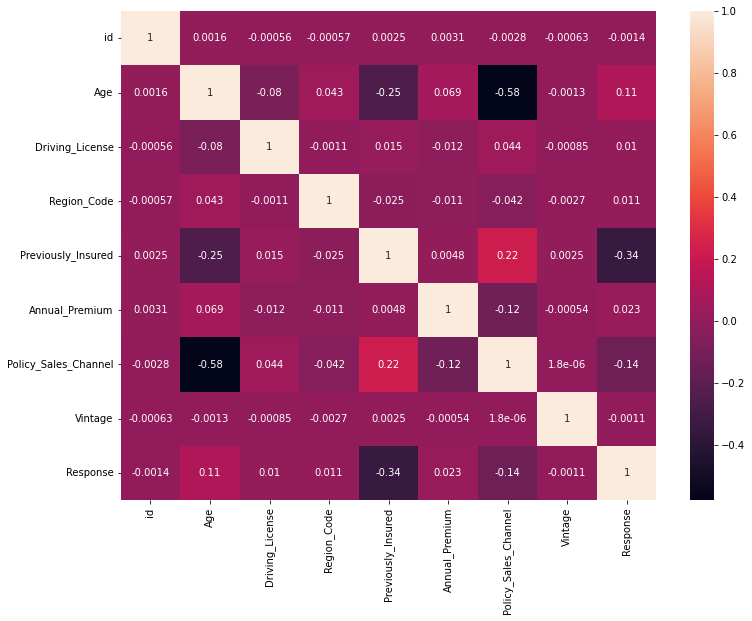

In [30]:
df.corrwith(train["Response"]).sort_values(ascending=False)
corr_df = train.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_df, annot=True, xticklabels=corr_df.columns, yticklabels=corr_df.columns)

corr_df = corr_df.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['1', '2']
corr_df = corr_df.reset_index()
corr_df.sort_values(by="corr", ascending=True).head(30)

high_corr = corr_df[(corr_df["corr"] >= 0.70) | (corr_df["corr"] <= -0.70)]
high_corr

In [31]:
train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
train=pd.get_dummies(train,drop_first=True)
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,1,1,44,1,28.0,0,40454.0,26.0,217,1,0,1,1
1,2,1,76,1,3.0,0,33536.0,26.0,183,0,0,0,0
2,3,1,47,1,28.0,0,38294.0,26.0,27,1,0,1,1
3,4,1,21,1,11.0,1,28619.0,152.0,203,0,1,0,0
4,5,0,29,1,41.0,1,27496.0,152.0,39,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.0,1,30170.0,26.0,88,0,0,0,0
381105,381106,1,30,1,37.0,1,40016.0,152.0,131,0,1,0,0
381106,381107,1,21,1,30.0,1,35118.0,160.0,161,0,1,0,0
381107,381108,0,68,1,14.0,0,44617.0,124.0,74,0,0,1,1


In [32]:
train=train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train['Vehicle_Age_lt_1_Year']=train['Vehicle_Age_lt_1_Year'].astype('int')
train['Vehicle_Age_gt_2_Years']=train['Vehicle_Age_gt_2_Years'].astype('int')
train['Vehicle_Damage_Yes']=train['Vehicle_Damage_Yes'].astype('int')
train["premium_age_ratio"] = train["Annual_Premium"]/train["Age"]
train["premium_vintage_ratio"] = train["Annual_Premium"]/train["Vintage"]
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes,premium_age_ratio,premium_vintage_ratio
0,1,1,44,1,28.0,0,40454.0,26.0,217,1,0,1,1,919.409091,186.423963
1,2,1,76,1,3.0,0,33536.0,26.0,183,0,0,0,0,441.263158,183.256831
2,3,1,47,1,28.0,0,38294.0,26.0,27,1,0,1,1,814.765957,1418.296296
3,4,1,21,1,11.0,1,28619.0,152.0,203,0,1,0,0,1362.809524,140.980296
4,5,0,29,1,41.0,1,27496.0,152.0,39,0,1,0,0,948.137931,705.025641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.0,1,30170.0,26.0,88,0,0,0,0,407.702703,342.840909
381105,381106,1,30,1,37.0,1,40016.0,152.0,131,0,1,0,0,1333.866667,305.465649
381106,381107,1,21,1,30.0,1,35118.0,160.0,161,0,1,0,0,1672.285714,218.124224
381107,381108,0,68,1,14.0,0,44617.0,124.0,74,0,0,1,1,656.132353,602.932432


In [33]:
num_feat = ['Age','Vintage','premium_age_ratio','premium_vintage_ratio']
ss = StandardScaler()
train[num_feat] = ss.fit_transform(train[num_feat])
mm = MinMaxScaler()
train[['Annual_Premium']] = mm.fit_transform(train[['Annual_Premium']])
train=train.drop('id',axis=1)
cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes']
for column in cat_feat:
    train[column] = train[column].astype('str')

In [34]:
test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
test=pd.get_dummies(test,drop_first=True)
test=test.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test['Vehicle_Age_lt_1_Year']=test['Vehicle_Age_lt_1_Year'].astype('int')
test['Vehicle_Age_gt_2_Years']=test['Vehicle_Age_gt_2_Years'].astype('int')
test['Vehicle_Damage_Yes']=test['Vehicle_Damage_Yes'].astype('int')
test["premium_age_ratio"] = test["Annual_Premium"]/test["Age"]
test["premium_vintage_ratio"] = test["Annual_Premium"]/test["Vintage"]
test=test.drop('id',axis=1)
ss = StandardScaler()
test[num_feat] = ss.fit_transform(test[num_feat])


mm = MinMaxScaler()
test[['Annual_Premium']] = mm.fit_transform(test[['Annual_Premium']])
for column in cat_feat:
    test[column] = test[column].astype('str')

In [35]:
training_data, testing_data = train.drop('Response', axis=1),train['Response']
x_train, x_test, y_train, y_test = train_test_split(training_data,testing_data, test_size=0.2, random_state=42)
x_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes,premium_age_ratio,premium_vintage_ratio
332803,0,0.011438,1,15.0,0,0.239200,55.0,0.868311,0,0,1,0.762207,-0.241018
116248,1,-0.053030,1,11.0,0,0.097096,26.0,-1.498095,0,0,1,-0.505070,0.797477
255005,1,-1.084517,1,30.0,1,0.203098,152.0,0.139267,1,0,0,1.950175,-0.167140
317474,0,-1.020049,1,41.0,1,0.126090,151.0,1.465888,1,0,0,0.610270,-0.477626
344212,1,1.107392,1,48.0,0,0.000000,154.0,0.007800,0,1,1,-1.449741,-0.640800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0,-0.955581,1,36.0,1,0.094893,152.0,1.585403,1,0,0,0.059675,-0.526672
365838,1,1.107392,1,35.0,0,0.183920,124.0,1.716870,0,0,1,-0.283800,-0.415878
131932,0,-1.084517,1,2.0,0,0.077204,152.0,-0.936372,1,0,1,-0.081339,-0.213171
146867,1,0.333777,1,32.0,1,0.000000,156.0,-1.235161,0,0,1,-1.428107,-0.576788


In [36]:
x_test

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes,premium_age_ratio,premium_vintage_ratio
200222,0,-1.148985,1,3.0,1,0.084583,160.0,-0.984179,1,0,0,0.112347,-0.147817
49766,1,1.042924,1,15.0,0,0.165893,26.0,-0.625632,0,0,1,-0.377517,0.007921
172201,0,0.140374,1,3.0,0,0.000000,26.0,-0.769051,0,0,1,-1.420720,-0.618129
160713,0,-0.826645,1,11.0,0,0.000000,151.0,1.358324,1,0,0,-1.358213,-0.654036
53272,1,0.785053,1,40.0,0,0.149279,124.0,1.322470,0,0,1,-0.402848,-0.434790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258403,1,-1.020049,1,15.0,0,0.098894,152.0,0.210976,1,0,1,0.190511,-0.420332
234155,0,-1.213453,1,15.0,1,0.140781,160.0,0.940020,1,0,0,1.191956,-0.416366
24476,0,-0.697709,1,8.0,1,0.223328,152.0,0.605377,1,0,0,1.461115,-0.224851
60423,0,-1.148985,1,3.0,1,0.142599,160.0,-1.199306,1,0,0,1.093108,0.444732


In [38]:
for column in cat_feat:
    x_train[column] = x_train[column].astype('int')
    x_test[column] = x_test[column].astype('int')
for column in num_feat:
    x_train[column] = x_train[column].astype('int')
    x_test[column] = x_test[column].astype('int')

In [39]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train,eval_metric='mlogloss')
pred_xgb = model_xgb.predict(x_test) 
predictions_xgb = [round(value) for value in pred_xgb]
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
print("Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Accuracy: 87.49%


In [40]:
X_train, Y_train = train.drop("Response",axis = 1), train["Response"]
X_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes,premium_age_ratio,premium_vintage_ratio
0,1,0.333777,1,28.0,0,0.179957,26.0,0.748795,0,1,1,0.023841,-0.327306
1,1,2.396751,1,3.0,0,0.147043,26.0,0.342443,0,0,0,-0.783760,-0.333165
2,1,0.527181,1,28.0,0,0.169680,26.0,-1.521998,0,1,1,-0.152904,1.951662
3,1,-1.148985,1,11.0,1,0.123649,152.0,0.581474,1,0,0,0.772756,-0.411377
4,0,-0.633242,1,41.0,1,0.118306,152.0,-1.378580,1,0,0,0.072365,0.632109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,1,2.267815,1,26.0,1,0.131028,26.0,-0.792954,0,0,0,-0.840444,-0.037934
381105,1,-0.568774,1,37.0,1,0.177873,152.0,-0.279037,1,0,0,0.723871,-0.107078
381106,1,-1.148985,1,30.0,1,0.154569,160.0,0.079509,1,0,0,1.295469,-0.268660
381107,0,1.881007,1,14.0,0,0.199763,124.0,-0.960275,0,1,1,-0.420840,0.443236


In [41]:
for column in cat_feat:
    X_train[column] = X_train[column].astype('int')
    test[column] = test[column].astype('int')
for column in num_feat:
    X_train[column] = X_train[column].astype('int')
    test[column] = test[column].astype('int')
from xgboost import XGBClassifier, plot_importance

model2 = XGBClassifier(eval_metric='mlogloss')
model2.fit(X_train, Y_train)

y_pred1 = model2.predict(test)
predictions2 = [round(value) for value in y_pred1]
test_2 = pd.DataFrame()
test_2['Response'] = sub['Response']
test_2["Pred_Response"] = predictions2
test_2

,Response,Pred_Response
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
127032,0,0
127033,0,0
127034,0,0
127035,0,0


In [42]:
accuracy_2 = accuracy_score(test_2['Response'].values, test_2['Pred_Response'].values)
print("Accuracy: %.2f%%" % (accuracy_2 * 100.0))

Accuracy: 99.68%
